<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/Version3_DeepUnfoldQFL_tensorCircuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorcircuit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 9.9 MB/s eta 0:00:00


In [38]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

K = tc.set_backend('jax')
key = jax.random.PRNGKey(42)
tf.random.set_seed(42)


dataset = 'mnist'
# dataset = 'fashion'
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

T=5
n = 8
n_node = 8
k = 20

def filter(x, y, class_list):
    keep = jnp.zeros(len(y)).astype(bool)
    for c in class_list:
        keep = keep | (y == c)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    #print("Length of probability:",len(probs))
    #print(-jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1)))
    return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1))
loss = K.jit(loss, static_argnums=[3])

def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

In [37]:
# numpy data
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
elif dataset == 'fashion':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
y_test = jax.nn.one_hot(y_test, n_node)

def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y


In [19]:

def Unfolded_FLtraining(params_list,opt_state_list):


  paramslist_all = []
  xlist_all = []
  ylist_all = []
  opt_statenodeall=[]



  params_listnode=[]
  xnode=[]
  ynode=[]
  opt_statenode=[]
  loss_list=[]
  acc_list = []


  params_list=params_list
  opt_state_list=opt_state_list

  for t in tqdm(range(T), leave=False):
    #for b in range(100):
      print("Iteration ", t)


      params_lists=[]
      xnodelists=[]
      ynodelists=[]
      for node in range(n_node-1):
        try:
            x, y = next(iter_list[node])
        except StopIteration:
            iter_list[node] = iter(data_list[node])
            x, y = next(iter_list[node])
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params_list[node], x, y, k)
        updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
        params_list[node] = optax.apply_updates(params_list[node], updates)

        params_listnode.append(params_list[node])
        opt_statenode.append(opt_state_list[node])
        xnode.append(x)
        ynode.append(y)

      avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
      for node in range(n_node-1):
        params_list[node] = avg_params

      paramslist_all.append(params_listnode)
      xlist_all.append(xnode)
      ylist_all.append(ynode)
      opt_statenodeall.append(opt_statenode)
        #if b % 25 == 0:
      avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
      loss_list.append(avg_loss)
      acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
      print(f"Epoch {t}, loss {avg_loss}, accuracy {acc_list[-1]}")

  plt.plot(loss_list)
  plt.plot(acc_list)
  plt.legend(['loss', 'accuracy'])
  plt.ylim(0, 3)
  plt.show()

  #jnp.save(f'./{dataset}/fedavg_loss.npy', loss_list)
  #jnp.save(f'./{dataset}/fedavg_acc.npy', acc_list)

  return paramslist_all, xlist_all, ylist_all, opt_statenodeall



In [39]:
def dunloss(paramslist_all, xlist_all, ylist_all, k): #pass karanawa iteration one and two node wala params and x,y
#e pass karan param tika man ganna one fed process eke yaddi save karagathha ewa.
#me process ekedi api eka eka iteration eke nemei all iteration waladi loss balala params set eka update keranwa.
    losses=[]
    # Iterate through the values row-wise for the specified column
    for t in range (T):
      for node in range(n_node-1):

        #value = paramslist_all[t][node]
        #inputs = xlist_all[t][node]

        # Print the shape of the inputs for debugging
        #print(f"Node: {node}, Iteration: {t}, Input Shape: {inputs.shape}")


        #print(f"Value for Column {0} Row {row + 1}: {value}")
        c = tc.Circuit(n, inputs=xlist_all[t][node])
        probs = readout(c)
        loss = -jnp.mean(jnp.sum(ylist_all[t][node] * jnp.log(probs + 1e-7), axis=-1))
        #losses.append(loss)
        #print(f"Value for Column {0} Row {row + 1}: {probs}")
    #return jnp.sum(losses)  # Sum the losses for all nodes and iterations
    return -jnp.mean(jnp.sum(ylist_all[t][node] * jnp.log(probs + 1e-7), axis=-1))

dunloss = K.jit(dunloss, static_argnums=[3])

compute_dunloss = K.jit(K.vectorized_value_and_grad(dunloss, vectorized_argnums=[1, 2]), static_argnums=[3])

100%|██████████| 7/7 [00:00<00:00, 31.89it/s]


Unfolding layer 0


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration  0


 20%|██        | 1/5 [00:04<00:17,  4.47s/it]

Epoch 0, loss 2.070585250854492, accuracy 0.169921875
Iteration  1


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

Epoch 1, loss 2.054739475250244, accuracy 0.166015625
Iteration  2


 60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

Epoch 2, loss 2.0378098487854004, accuracy 0.173828125
Iteration  3


 80%|████████  | 4/5 [00:14<00:03,  3.49s/it]

Epoch 3, loss 2.0215420722961426, accuracy 0.1748046875
Iteration  4


Epoch 4, loss 2.006730794906616, accuracy 0.1728515625


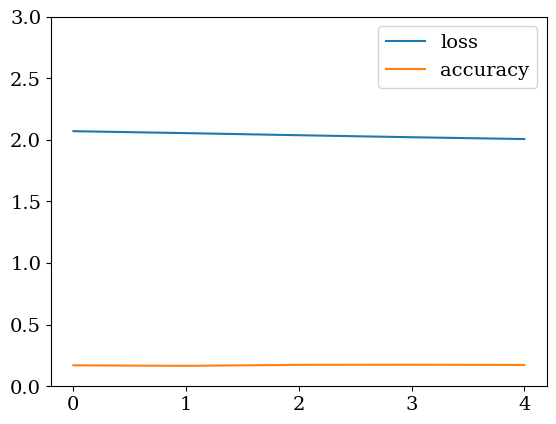

460.49744
884.9363
1312.4197
1783.8882
2254.972
2715.3345
3259.1133
460.49744
884.9363
1312.4197
1783.8882
2254.972
2715.3345
3259.1133
460.49744
884.9363
1312.4197
1783.8882
2254.972
2715.3345
3259.1133
460.49744
884.9363
1312.4197
1783.8882
2254.972
2715.3345
3259.1133
460.49744
884.9363
1312.4197
1783.8882
2254.972
2715.3345
3259.1133
Sum of squared in iteration 0  is  3259.1133
Sum of squared in iteration 1  is  3259.1133
Sum of squared in iteration 2  is  3259.1133
Sum of squared in iteration 3  is  3259.1133
Sum of squared in iteration 4  is  3259.1133
Deep unfolding Layer 0 done
Unfolding layer 1


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration  0


 20%|██        | 1/5 [00:03<00:13,  3.35s/it]

Epoch 0, loss 2.010016918182373, accuracy 0.1806640625
Iteration  1


 40%|████      | 2/5 [00:06<00:09,  3.26s/it]

Epoch 1, loss 1.9930768013000488, accuracy 0.1865234375
Iteration  2


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

Epoch 2, loss 1.9779231548309326, accuracy 0.1875
Iteration  3


 80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

Epoch 3, loss 1.9654345512390137, accuracy 0.1875
Iteration  4


Epoch 4, loss 1.950136423110962, accuracy 0.1943359375


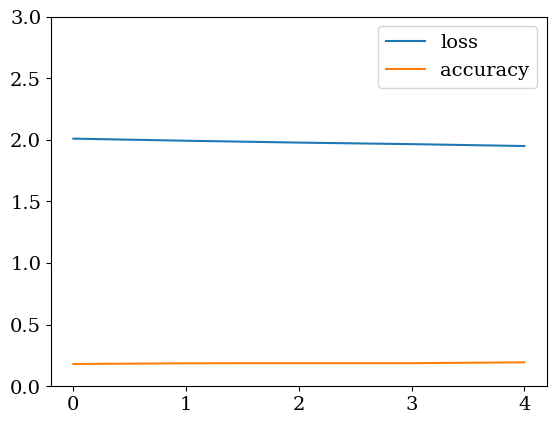

72.14206
144.48607
215.78136
287.95898
361.01572
432.9206
505.2682
72.14206
144.48607
215.78136
287.95898
361.01572
432.9206
505.2682
72.14206
144.48607
215.78136
287.95898
361.01572
432.9206
505.2682
72.14206
144.48607
215.78136
287.95898
361.01572
432.9206
505.2682
72.14206
144.48607
215.78136
287.95898
361.01572
432.9206
505.2682
Sum of squared in iteration 0  is  505.2682
Sum of squared in iteration 1  is  505.2682
Sum of squared in iteration 2  is  505.2682
Sum of squared in iteration 3  is  505.2682
Sum of squared in iteration 4  is  505.2682
Deep unfolding Layer 1 done


In [50]:
params_list = []
opt_state_list = []
data_list = []
iter_list = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
    data_list.append(data)
    iter_list.append(iter(data))

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)

Unfoldlayers=2
for l in range(Unfoldlayers):
    print(f"Unfolding layer", l)
    paramslist_all, xlist_all, ylist_all, opt_statenodeall=Unfolded_FLtraining(params_list,opt_state_list)

    unfoldlayer_wise_weights=[]

    loss_val, grad_val = compute_dunloss(paramslist_all, xlist_all, ylist_all, k)

    for t in range (T):
      for node in range(n_node-1):
          updates,opt_statenodeall[t][node]= opt.update(grad_val[t][node], opt_statenodeall[t][node], paramslist_all[t][node])
          paramslist_all[t][node] = optax.apply_updates(paramslist_all[t][node], updates)
          #print(paramslist_all[t][node])
          #Assign last parameter set aggregation in last iteration in first deep layer
    #at the end of the last iteration of each deep unfolding layer,  need to get average parameters and assign it to each nodes parameters.
    #if t==T:
    avg_params = jnp.mean(jnp.stack(paramslist_all[T-1], axis=0), axis=0)
      #params=avg_params
    for node in range(n_node-1):
          params_list[node] = avg_params

    #Calculate the weights using parameters now.
    # Calculate sum of squares for each node and get normailzed values
    sum_of_squares_per_iter = []
    for t in range(T):
        sum_of_squares_for_t =0
        for node in range(n_node-1):
            sum_of_squares_for_t+=jnp.sum(paramslist_all[t][node]**2)
            print(sum_of_squares_for_t)
            sum_of_squares_per_iter.append(sum_of_squares_for_t)
    for t in range(T):
      print("Sum of squared in iteration",t," is ", sum_of_squares_per_iter[t])

    normalized_weights_Per_it = []
    for t in range(T):
        normalized_weights_node=[]
        for node in range(n_node-1):
           #print("Iteration", t)
           nodeweights=jnp.sum((paramslist_all[t][node])**2)/jnp.array(sum_of_squares_per_iter[t])
           #print(f"Iteration {t}, Node {node}", nodeweights )
           #node_sum_of_squares[t][node] = (jnp.sum(paramslist_all[t][node]**2))/jnp.array(sum_of_squares_per_iter[t])
           #print(len(node_sum_of_squares[]))

           normalized_weights_node.append(nodeweights)
        normalized_weights_Per_it.append(normalized_weights_node)
    #print(normalized_weights_Per_it)

    import csv

    with open('weights.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)

      # Write the header row
      writer.writerow(['Iteration', 'Node', 'Weight'])

      # Write the data rows
      for i in range(T):
        for j in range(n_node-1):
            writer.writerow([i, j, normalized_weights_Per_it[i][j]])

    with open('weights.csv', 'r') as csvfile:
      reader = csv.reader(csvfile)

      # Read the header row
      header = next(reader)

      # Read the data rows
      for row in reader:
        iteration, node, weight = row
        #print(f'Iteration {iteration}, Node {node}, Weight {weight}')

    print("Deep unfolding", "Layer", l, "done")

In [46]:
# Write the data rows
for i in range(T):
    for j in range(n_node-1):
        print([i, j, normalized_weights_Per_it[i][j]])

[0, 0, Array(0.14387189, dtype=float32)]
[0, 1, Array(0.1430365, dtype=float32)]
[0, 2, Array(0.14209446, dtype=float32)]
[0, 3, Array(0.14292443, dtype=float32)]
[0, 4, Array(0.14296223, dtype=float32)]
[0, 5, Array(0.14301957, dtype=float32)]
[0, 6, Array(0.14209089, dtype=float32)]
[1, 0, Array(0.14387189, dtype=float32)]
[1, 1, Array(0.1430365, dtype=float32)]
[1, 2, Array(0.14209446, dtype=float32)]
[1, 3, Array(0.14292443, dtype=float32)]
[1, 4, Array(0.14296223, dtype=float32)]
[1, 5, Array(0.14301957, dtype=float32)]
[1, 6, Array(0.14209089, dtype=float32)]
[2, 0, Array(0.14387189, dtype=float32)]
[2, 1, Array(0.1430365, dtype=float32)]
[2, 2, Array(0.14209446, dtype=float32)]
[2, 3, Array(0.14292443, dtype=float32)]
[2, 4, Array(0.14296223, dtype=float32)]
[2, 5, Array(0.14301957, dtype=float32)]
[2, 6, Array(0.14209089, dtype=float32)]
[3, 0, Array(0.14387189, dtype=float32)]
[3, 1, Array(0.1430365, dtype=float32)]
[3, 2, Array(0.14209446, dtype=float32)]
[3, 3, Array(0.14292

In [41]:
   for t in tqdm(range(T)):
        weights_dict={}
        with open('weights.csv', 'r') as csvfile:
          reader = csv.reader(csvfile)
          # Read the header row
          header = next(reader)
          # Read the data rows for the desired iteration
          for row in reader:
            iteration, node, weight = map(float, row)  # Convert to int assuming iteration and node are integers
            if iteration == t:
                  weights_dict[node] = weight
          # Now you have a dictionary with node as keys and weights as values for the specified iteration
        print("Weights for iteration", t, ":", weights_dict)

100%|██████████| 5/5 [00:00<00:00, 1131.76it/s]

Weights for iteration 0 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
Weights for iteration 1 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
Weights for iteration 2 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
Weights for iteration 3 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
Weights for iteration 4 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}


In [43]:
if __name__ == '__main__':
#def fedlearning(weights,method,params):
    # numpy data
    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    ind = y_test == 9
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_test == 8
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_train == 9
    x_train, y_train = x_train[~ind], y_train[~ind]
    ind = y_train == 8
    x_train, y_train = x_train[~ind], y_train[~ind]

    x_train = x_train / 255.0
    if encoding_mode == 'vanilla':
        mean = 0
    elif encoding_mode == 'mean':
        mean = jnp.mean(x_train, axis=0)
    elif encoding_mode == 'half':
        mean = 0.5
    x_train = x_train - mean
    x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

    x_test = x_test / 255.0
    x_test = x_test - mean
    x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
    y_test = jax.nn.one_hot(y_test, n_node)

    world_train_loss = []
    world_test_loss = []
    world_train_acc = []
    world_test_acc = []
    paramslist_all = []
    xlist_all = []
    ylist_all = []
    opt_statenodeall=[]

    params_list = []
    opt_state_list = []
    data_list = []
    iter_list = []
    params_lists=[]
    xnodelists=[]
    ynodelists=[]
    for node in range(n_node-1):
        x_train_node, y_train_node = filter(x_train, y_train, [0, node+1])
        # x_train_node, y_train_node = x_train, jax.nn.one_hot(y_train, n_node)
        data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
        data_list.append(data)
        iter_list.append(iter(data))

        key, subkey = jax.random.split(key)
        params = jax.random.normal(subkey, (3 * k, n))
            #params=params
        opt = optax.adam(learning_rate=1e-2)
        opt_state = opt.init(params)
        params_list.append(params)
        opt_state_list.append(opt_state)

        #weights=[0.14114611,0.14295208,14467925,14332035,14269364,14413896,14106953]

    for t in tqdm(range(T)):
        weights_dict={}
        with open('weights.csv', 'r') as csvfile:
          reader = csv.reader(csvfile)
          # Read the header row
          header = next(reader)
          # Read the data rows for the desired iteration
          for row in reader:
            iteration, node, weight = map(float, row)  # Convert to int assuming iteration and node are integers
            if iteration == t:
                  weights_dict[node] = weight
          # Now you have a dictionary with node as keys and weights as values for the specified iteration
        print("Weights for iteration", t, ":", weights_dict)


        loss_list = []
        acc_list = []
        params_listnode=[]
        xnode=[]
        ynode=[]
        opt_statenode=[]
        weighted_paramlist=[]

        for node in range(n_node-1):
            #for b in range(100):
            #print("node", node)

            try:
              x, y = next(iter_list[node])
            except StopIteration:
              iter_list[node] = iter(data_list[node])
              x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            #print("loss lenth",node, "is", len(loss_val))
            #print("grad lenth",node, "is", len(grad_val))
            #print("para length",node, "is", len(params_list[node]))
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)
                #print(loss_val)
            #if method=="dunQFL":
            #params_list[node] = params_list[node]*normalized_weights_Per_it[t][node]
            #if method=="QFL":
              #params_list[node]=params_list[node]


            #print(weighted_paramlist[node])
            params_listnode.append(params_list[node])
            opt_statenode.append(opt_state_list[node])
            xnode.append(x)
            ynode.append(y)
            print(weights_dict[node])
            params_list[node]=params_list[node] * weights_dict[node]

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)


        for node in range(n_node-1):
            params_list[node] = avg_params

                #if b % 25 == 0:
        avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
        loss_list.append(avg_loss)
        acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
        tqdm.write(f"Iteration {t}, loss {avg_loss}, accuracy {acc_list[-1]}")

        paramslist_all.append(params_listnode)
        xlist_all.append(xnode)
        ylist_all.append(ynode)
        opt_statenodeall.append(opt_statenode)
        test_acc = jnp.mean(pred(avg_params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))
        test_loss = -jnp.mean(jnp.log(pred(avg_params, x_test[:1024], k)) * y_test[:1024])

        world_train_loss.append(loss_list)
        world_test_loss.append(test_loss)
        world_train_acc.append(acc_list)
        world_test_acc.append(test_acc)
        #tqdm.write(f"world {world}: test loss {test_loss}, test accuracy {test_acc}")
        #print(len(paramslist_all[0]))

    #return paramslist_all, xlist_all, ylist_all,opt_statenodeall

    #avg_test_loss = jnp.mean(jnp.array(world_test_loss), axis=0)
    #avg_test_acc = jnp.mean(jnp.array(world_test_acc), axis=0)
    #std_test_loss = jnp.std(jnp.array(world_test_loss), axis=0)
    #std_test_acc = jnp.std(jnp.array(world_test_acc), axis=0)
    #print(f'test loss: {avg_test_loss}+-{std_test_loss}, test acc: {avg_test_acc}+-{std_test_acc}')

  0%|          | 0/5 [00:00<?, ?it/s]

Weights for iteration 0 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
0.14247216
0.14304182
0.14500764
0.14281717
0.14207053
0.1438871
0.14070356


  0%|          | 0/5 [00:03<?, ?it/s]

Iteration 0, loss 3.1473207473754883, accuracy 0.134765625


 20%|██        | 1/5 [00:09<00:37,  9.25s/it]

Weights for iteration 1 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
0.14247216
0.14304182
0.14500764
0.14281717
0.14207053
0.1438871
0.14070356


 20%|██        | 1/5 [00:12<00:37,  9.25s/it]

Iteration 1, loss 3.28305721282959, accuracy 0.1298828125


 40%|████      | 2/5 [00:16<00:24,  8.11s/it]

Weights for iteration 2 : {0.0: 0.14247216, 1.0: 0.14304182, 2.0: 0.14500764, 3.0: 0.14281717, 4.0: 0.14207053, 5.0: 0.1438871, 6.0: 0.14070356}
0.14247216
0.14304182
0.14500764
0.14281717
0.14207053
0.1438871
0.14070356


 40%|████      | 2/5 [00:21<00:24,  8.11s/it]

Iteration 2, loss 3.2869949340820312, accuracy 0.130859375


 40%|████      | 2/5 [00:23<00:35, 11.67s/it]


KeyboardInterrupt: 

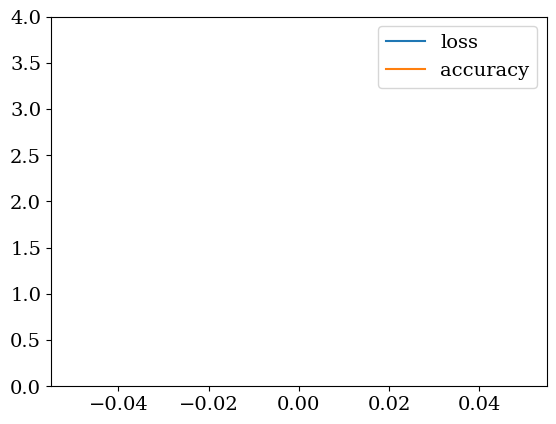

In [31]:
  plt.plot(loss_list)
  plt.plot(acc_list)
  plt.legend(['loss', 'accuracy'])
  plt.ylim(0, 4)
  plt.show()

In [ ]:

import csv

# Write the world_train_loss list to a CSV file
with open(f'QFLworld_train_loss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Node', 'Loss'])

    # Write the data rows
    for i in range(len(world_train_loss)):
        for j in range(len(world_train_loss[i])):
            writer.writerow([i, j, world_train_loss[i][j]])

# Write the world_test_loss list to a CSV file
with open(f'QFLworld_test_loss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Loss'])

    # Write the data rows
    for i in range(len(world_test_loss)):
        writer.writerow([i, world_test_loss[i]])

# Write the world_train_acc list to a CSV file
with open(f'QFLworld_train_acc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Node', 'Accuracy'])

    # Write the data rows
    for i in range(len(world_train_acc)):
        for j in range(len(world_train_acc[i])):
            writer.writerow([i, j, world_train_acc[i][j]])

# Write the world_test_acc list to a CSV file
with open(f'QFLworld_test_acc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Accuracy'])

    # Write the data rows
    for i in range(len(world_test_acc)):
        writer.writerow([i, world_test_acc[i]])

In [ ]:
#Deep unfolding process loss calcualtion#
def dunloss(paramslist_all, xlist_all, ylist_all, k): #pass karanawa iteration one and two node wala params and x,y
#e pass karan param tika man ganna one fed process eke yaddi save karagathha ewa.
#me process ekedi api eka eka iteration eke nemei all iteration waladi loss balala params set eka update keranwa.

    # Iterate through the values row-wise for the specified column
    for node in range(n_node-1):
      for t in range (T):
        value = paramslist_all[t][node]
        #print(f"Value for Column {0} Row {row + 1}: {value}")
        c = tc.Circuit(n, inputs=xlist_all[t][node])
        probs = readout(c)
        #print(f"Value for Column {0} Row {row + 1}: {probs}")
        return -jnp.mean(jnp.sum(ylist_all[t][node] * jnp.log(probs + 1e-7), axis=-1))

    #for row in range(3):
      #for t in range(2):
        #
        #c = clf(paramslist_all[n][t], c, k)
        #probs = readout(c)
        #return -jnp.mean(jnp.sum(ylist_all[n][t] * jnp.log(probs + 1e-7), axis=-1))
dunloss = K.jit(dunloss, static_argnums=[3])

compute_dunloss = K.jit(K.vectorized_value_and_grad(dunloss, vectorized_argnums=[1, 2]), static_argnums=[3])

In [ ]:
M=10
#key, subkey = jax.random.split(key)
#params = jax.random.normal(subkey, (3 * k, n))
#opt = optax.adam(learning_rate=1e-2)
#opt_state = opt.init(params)
for loop in range (M):
    unfoldlayer_wise_weights=[]
    #paramslist_all, xlist_all, ylist_all,opt_statenodeall = fedlearning(params) #function call for fed process.
    loss_val, grad_val = compute_dunloss(paramslist_all, xlist_all, ylist_all, k)
    print("Unfolding layer", loop)

    for t in range (T):
      for node in range(n_node-1):
          updates,opt_statenodeall[t][node]= opt.update(grad_val[t][node], opt_statenodeall[t][node], paramslist_all[t][node])
          paramslist_all[t][node] = optax.apply_updates(paramslist_all[t][node], updates)
          #print(paramslist_all[t][node])
          #Assign last parameter set aggregation in last iteration in first deep layer
    #at the end of the last iteration of each deep unfolding layer,  need to get average parameters and assign it to each nodes parameters.
    if t==T:
      avg_params = jnp.mean(jnp.stack(paramslist_all[T-1], axis=0), axis=0)
      #params=avg_params
      for node in range(n_node-1):
            params_list[node] = avg_params


    #Calculate the weights using parameters now.
    # Calculate sum of squares for each node and get normailzed values
    sum_of_squares_per_iter = []
    for t in range(T):
        sum_of_squares_for_t =0
        for node in range(n_node-1):
            sum_of_squares_for_t+=jnp.sum(paramslist_all[t][node]**2)
            #print(sum_of_squares_for_t)
        sum_of_squares_per_iter.append(sum_of_squares_for_t)
        #print("Sum of squared in iteration",t," is ", sum_of_squares_per_iter[t])

    normalized_weights_Per_it = []
    for t in range(T):
        normalized_weights_node=[]
        for node in range(n_node-1):
           #print("Iteration", t)
           nodeweights=jnp.sum((paramslist_all[t][node])**2)/jnp.array(sum_of_squares_per_iter[t])
           #print(f"Iteration {t}, Node {node}", nodeweights )
           #node_sum_of_squares[t][node] = (jnp.sum(paramslist_all[t][node]**2))/jnp.array(sum_of_squares_per_iter[t])
           #print(len(node_sum_of_squares[]))

           normalized_weights_node.append(nodeweights)
        normalized_weights_Per_it.append(normalized_weights_node)
    #print(normalized_weights_Per_it)

    import csv

    with open('weights.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)

      # Write the header row
      writer.writerow(['Iteration', 'Node', 'Weight'])

      # Write the data rows
      for i in range(T):
        for j in range(n_node-1):
            writer.writerow([i, j, normalized_weights_Per_it[i][j]])




    with open('weights.csv', 'r') as csvfile:
      reader = csv.reader(csvfile)

      # Read the header row
      header = next(reader)

      # Read the data rows
      for row in reader:
        iteration, node, weight = row
        print(f'Iteration {iteration}, Node {node}, Weight {weight}')

print("Deep unfolding done")

Unfolding layer 0
Iteration 0, Node 0, Weight 0.5580365
Iteration 0, Node 1, Weight 0.07364059
Iteration 0, Node 2, Weight 0.07351377
Iteration 0, Node 3, Weight 0.073771246
Iteration 0, Node 4, Weight 0.073975004
Iteration 0, Node 5, Weight 0.07354213
Iteration 0, Node 6, Weight 0.07352078
Iteration 1, Node 0, Weight 0.5376451
Iteration 1, Node 1, Weight 0.07721078
Iteration 1, Node 2, Weight 0.07694454
Iteration 1, Node 3, Weight 0.076960795
Iteration 1, Node 4, Weight 0.07708155
Iteration 1, Node 5, Weight 0.07689273
Iteration 1, Node 6, Weight 0.07726447
Iteration 2, Node 0, Weight 0.54938555
Iteration 2, Node 1, Weight 0.07487465
Iteration 2, Node 2, Weight 0.07486672
Iteration 2, Node 3, Weight 0.07532531
Iteration 2, Node 4, Weight 0.075077884
Iteration 2, Node 5, Weight 0.075287275
Iteration 2, Node 6, Weight 0.07518258
Iteration 3, Node 0, Weight 0.5663277
Iteration 3, Node 1, Weight 0.07204376
Iteration 3, Node 2, Weight 0.07226076
Iteration 3, Node 3, Weight 0.07236921
Itera

In [ ]:
if __name__ == '__main__':
#def fedlearning(weights,method,params):
    # numpy data
    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    ind = y_test == 9
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_test == 8
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_train == 9
    x_train, y_train = x_train[~ind], y_train[~ind]
    ind = y_train == 8
    x_train, y_train = x_train[~ind], y_train[~ind]

    x_train = x_train / 255.0
    if encoding_mode == 'vanilla':
        mean = 0
    elif encoding_mode == 'mean':
        mean = jnp.mean(x_train, axis=0)
    elif encoding_mode == 'half':
        mean = 0.5
    x_train = x_train - mean
    x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

    x_test = x_test / 255.0
    x_test = x_test - mean
    x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
    y_test = jax.nn.one_hot(y_test, n_node)

    world_train_loss = []
    world_test_loss = []
    world_train_acc = []
    world_test_acc = []
    paramslist_all = []
    xlist_all = []
    ylist_all = []
    opt_statenodeall=[]
    for t in tqdm(range(T)):
        print("Iteration ", t)
        params_list = []
        opt_state_list = []
        data_list = []
        iter_list = []
        params_lists=[]
        xnodelists=[]
        ynodelists=[]
        for node in range(n_node-1):
            x_train_node, y_train_node = filter(x_train, y_train, [0, node+1])
            # x_train_node, y_train_node = x_train, jax.nn.one_hot(y_train, n_node)
            data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
            data_list.append(data)
            iter_list.append(iter(data))

            key, subkey = jax.random.split(key)
            params = jax.random.normal(subkey, (3 * k, n))
            #params=params
            opt = optax.adam(learning_rate=1e-2)
            opt_state = opt.init(params)
            params_list.append(params)
            opt_state_list.append(opt_state)

        loss_list = []
        acc_list = []
        params_listnode=[]
        xnode=[]
        ynode=[]
        opt_statenode=[]
        weighted_paramlist=[]
        for node in range(n_node-1):
            #for b in range(100):
            #print("node", node)

            try:
              x, y = next(iter_list[node])
            except StopIteration:
              iter_list[node] = iter(data_list[node])
              x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            #print("loss lenth",node, "is", len(loss_val))
            #print("grad lenth",node, "is", len(grad_val))
            #print("para length",node, "is", len(params_list[node]))
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)
                #print(loss_val)
            #if method=="dunQFL":
            #params_list[node] = params_list[node]*normalized_weights_Per_it[t][node]
            #if method=="QFL":
              #params_list[node]=params_list[node]


            #print(weighted_paramlist[node])
            params_listnode.append(params_list[node])
            opt_statenode.append(opt_state_list[node])
            xnode.append(x)
            ynode.append(y)


            #avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
            #instead above line
            ########################################

    #def calculate_weighted_average_params(params_list, normalized_weights_Per_it):
    # Convert the list of parameters to a JAX array
            params_array = jnp.stack(params_list, axis=0)

            # Expand dimensions of normalized_weights_Per_it to match params_array
            weights_expanded = jnp.expand_dims(normalized_weights_Per_it, axis=-1)

            # Calculate the weighted sum along the iteration axis
            weighted_sum_params = jnp.sum(params_array * weights_expanded, axis=0)

            # Calculate the total weight along the iteration axis
            total_weights = jnp.sum(weights_expanded, axis=0)

            # Calculate the average parameters
            avg_params = weighted_sum_params / total_weights
            #########################################

            for node in range(n_node-1):
                params_list[node] = avg_params

                #if b % 25 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list.append(avg_loss)
            acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            tqdm.write(f"Iteration {t}, loss {avg_loss}, accuracy {acc_list[-1]}")

        paramslist_all.append(params_listnode)
        xlist_all.append(xnode)
        ylist_all.append(ynode)
        opt_statenodeall.append(opt_statenode)
        test_acc = jnp.mean(pred(avg_params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))
        test_loss = -jnp.mean(jnp.log(pred(avg_params, x_test[:1024], k)) * y_test[:1024])

        world_train_loss.append(loss_list)
        world_test_loss.append(test_loss)
        world_train_acc.append(acc_list)
        world_test_acc.append(test_acc)
        #tqdm.write(f"world {world}: test loss {test_loss}, test accuracy {test_acc}")
        #print(len(paramslist_all[0]))

    #return paramslist_all, xlist_all, ylist_all,opt_statenodeall

    #avg_test_loss = jnp.mean(jnp.array(world_test_loss), axis=0)
    #avg_test_acc = jnp.mean(jnp.array(world_test_acc), axis=0)
    #std_test_loss = jnp.std(jnp.array(world_test_loss), axis=0)
    #std_test_acc = jnp.std(jnp.array(world_test_acc), axis=0)
    #print(f'test loss: {avg_test_loss}+-{std_test_loss}, test acc: {avg_test_acc}+-{std_test_acc}')

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration  0


  0%|          | 0/10 [00:26<?, ?it/s]

Iteration 0, loss 2.378636360168457, accuracy 0.119140625


  0%|          | 0/10 [00:36<?, ?it/s]

Iteration 0, loss 2.3321735858917236, accuracy 0.09765625


  0%|          | 0/10 [00:46<?, ?it/s]

Iteration 0, loss 2.232487678527832, accuracy 0.1015625


  0%|          | 0/10 [00:57<?, ?it/s]

Iteration 0, loss 2.3044190406799316, accuracy 0.1162109375


  0%|          | 0/10 [01:07<?, ?it/s]

Iteration 0, loss 2.3684639930725098, accuracy 0.1083984375


  0%|          | 0/10 [01:17<?, ?it/s]

Iteration 0, loss 2.412191152572632, accuracy 0.087890625


  0%|          | 0/10 [01:27<?, ?it/s]

Iteration 0, loss 2.408784866333008, accuracy 0.09375


 10%|█         | 1/10 [01:40<15:04, 100.48s/it]

Iteration  1


 10%|█         | 1/10 [01:50<15:04, 100.48s/it]

Iteration 1, loss 2.139474391937256, accuracy 0.158203125


 10%|█         | 1/10 [02:01<15:04, 100.48s/it]

Iteration 1, loss 2.1716184616088867, accuracy 0.15625


 10%|█         | 1/10 [02:11<15:04, 100.48s/it]

Iteration 1, loss 2.1790506839752197, accuracy 0.1337890625


 10%|█         | 1/10 [02:20<15:04, 100.48s/it]

Iteration 1, loss 2.125211238861084, accuracy 0.1630859375


 10%|█         | 1/10 [02:30<15:04, 100.48s/it]

Iteration 1, loss 2.1392173767089844, accuracy 0.15625


 10%|█         | 1/10 [02:40<15:04, 100.48s/it]

Iteration 1, loss 2.1928858757019043, accuracy 0.154296875


 10%|█         | 1/10 [02:50<15:04, 100.48s/it]

Iteration 1, loss 2.2975943088531494, accuracy 0.125


 20%|██        | 2/10 [03:07<12:18, 92.33s/it] 

Iteration  2


 20%|██        | 2/10 [03:17<12:18, 92.33s/it]

Iteration 2, loss 2.184457540512085, accuracy 0.1142578125


 20%|██        | 2/10 [03:27<12:18, 92.33s/it]

Iteration 2, loss 2.3922648429870605, accuracy 0.146484375


 20%|██        | 2/10 [03:36<12:18, 92.33s/it]

Iteration 2, loss 2.404451847076416, accuracy 0.125


 20%|██        | 2/10 [03:47<12:18, 92.33s/it]

Iteration 2, loss 2.4720406532287598, accuracy 0.0869140625


 20%|██        | 2/10 [03:57<12:18, 92.33s/it]

Iteration 2, loss 2.5601141452789307, accuracy 0.076171875


 20%|██        | 2/10 [04:07<12:18, 92.33s/it]

Iteration 2, loss 2.677370548248291, accuracy 0.0576171875


 20%|██        | 2/10 [04:16<12:18, 92.33s/it]

Iteration 2, loss 2.8052163124084473, accuracy 0.0576171875


 30%|███       | 3/10 [04:30<10:16, 88.13s/it]

Iteration  3


 30%|███       | 3/10 [04:40<10:16, 88.13s/it]

Iteration 3, loss 2.1984939575195312, accuracy 0.1572265625


 30%|███       | 3/10 [04:50<10:16, 88.13s/it]

Iteration 3, loss 2.2096493244171143, accuracy 0.158203125


 30%|███       | 3/10 [05:00<10:16, 88.13s/it]

Iteration 3, loss 2.201834201812744, accuracy 0.1357421875


 30%|███       | 3/10 [05:10<10:16, 88.13s/it]

Iteration 3, loss 2.1129510402679443, accuracy 0.171875


 30%|███       | 3/10 [05:20<10:16, 88.13s/it]

Iteration 3, loss 2.065094470977783, accuracy 0.142578125


 30%|███       | 3/10 [05:32<10:16, 88.13s/it]

Iteration 3, loss 2.142866373062134, accuracy 0.1298828125


 30%|███       | 3/10 [05:42<10:16, 88.13s/it]

Iteration 3, loss 2.23368501663208, accuracy 0.1181640625


 40%|████      | 4/10 [05:55<08:42, 87.01s/it]

Iteration  4


 40%|████      | 4/10 [06:06<08:42, 87.01s/it]

Iteration 4, loss 2.213921070098877, accuracy 0.1416015625


 40%|████      | 4/10 [06:15<08:42, 87.01s/it]

Iteration 4, loss 2.113245725631714, accuracy 0.1611328125


 40%|████      | 4/10 [06:25<08:42, 87.01s/it]

Iteration 4, loss 2.2411975860595703, accuracy 0.140625


 40%|████      | 4/10 [06:36<08:42, 87.01s/it]

Iteration 4, loss 2.279510974884033, accuracy 0.138671875


 40%|████      | 4/10 [06:46<08:42, 87.01s/it]

Iteration 4, loss 2.205343246459961, accuracy 0.1435546875


 40%|████      | 4/10 [06:56<08:42, 87.01s/it]

Iteration 4, loss 2.2385106086730957, accuracy 0.1396484375


 40%|████      | 4/10 [07:05<08:42, 87.01s/it]

Iteration 4, loss 2.3707942962646484, accuracy 0.134765625


 50%|█████     | 5/10 [07:18<07:08, 85.61s/it]

Iteration  5


 50%|█████     | 5/10 [07:29<07:08, 85.61s/it]

Iteration 5, loss 2.1921727657318115, accuracy 0.115234375


 50%|█████     | 5/10 [07:39<07:08, 85.61s/it]

Iteration 5, loss 2.211344003677368, accuracy 0.1103515625


 50%|█████     | 5/10 [07:49<07:08, 85.61s/it]

Iteration 5, loss 2.2274608612060547, accuracy 0.1240234375


 50%|█████     | 5/10 [07:58<07:08, 85.61s/it]

Iteration 5, loss 2.286057233810425, accuracy 0.107421875


 50%|█████     | 5/10 [08:08<07:08, 85.61s/it]

Iteration 5, loss 2.3344569206237793, accuracy 0.1005859375


 50%|█████     | 5/10 [08:18<07:08, 85.61s/it]

Iteration 5, loss 2.3513309955596924, accuracy 0.0849609375


 50%|█████     | 5/10 [08:28<07:08, 85.61s/it]

Iteration 5, loss 2.3846497535705566, accuracy 0.0634765625


 60%|██████    | 6/10 [08:42<05:39, 84.93s/it]

Iteration  6


 60%|██████    | 6/10 [08:52<05:39, 84.93s/it]

Iteration 6, loss 2.2418227195739746, accuracy 0.0966796875


 60%|██████    | 6/10 [09:01<05:39, 84.93s/it]

Iteration 6, loss 2.1449809074401855, accuracy 0.169921875


 60%|██████    | 6/10 [09:11<05:39, 84.93s/it]

Iteration 6, loss 2.234755277633667, accuracy 0.095703125


 60%|██████    | 6/10 [09:22<05:39, 84.93s/it]

Iteration 6, loss 2.3311679363250732, accuracy 0.0791015625


 60%|██████    | 6/10 [09:32<05:39, 84.93s/it]

Iteration 6, loss 2.4094185829162598, accuracy 0.11328125


 60%|██████    | 6/10 [09:42<05:39, 84.93s/it]

Iteration 6, loss 2.4561171531677246, accuracy 0.166015625


 60%|██████    | 6/10 [09:52<05:39, 84.93s/it]

Iteration 6, loss 2.5084753036499023, accuracy 0.1533203125


 70%|███████   | 7/10 [10:14<04:22, 87.39s/it]

Iteration  7


 70%|███████   | 7/10 [10:26<04:22, 87.39s/it]

Iteration 7, loss 2.2512340545654297, accuracy 0.169921875


 70%|███████   | 7/10 [10:36<04:22, 87.39s/it]

Iteration 7, loss 2.122661828994751, accuracy 0.1904296875


 70%|███████   | 7/10 [10:46<04:22, 87.39s/it]

Iteration 7, loss 2.101494312286377, accuracy 0.1865234375


 70%|███████   | 7/10 [10:56<04:22, 87.39s/it]

Iteration 7, loss 2.187617063522339, accuracy 0.171875


 70%|███████   | 7/10 [11:06<04:22, 87.39s/it]

Iteration 7, loss 2.2762887477874756, accuracy 0.115234375


 70%|███████   | 7/10 [11:16<04:22, 87.39s/it]

Iteration 7, loss 2.319890022277832, accuracy 0.1181640625


 70%|███████   | 7/10 [11:25<04:22, 87.39s/it]

Iteration 7, loss 2.3328769207000732, accuracy 0.138671875


 80%|████████  | 8/10 [11:39<02:53, 86.54s/it]

Iteration  8


 80%|████████  | 8/10 [11:50<02:53, 86.54s/it]

Iteration 8, loss 2.2201318740844727, accuracy 0.13671875


 80%|████████  | 8/10 [12:00<02:53, 86.54s/it]

Iteration 8, loss 2.27400541305542, accuracy 0.0791015625


 80%|████████  | 8/10 [12:10<02:53, 86.54s/it]

Iteration 8, loss 2.299978733062744, accuracy 0.1083984375


 80%|████████  | 8/10 [12:20<02:53, 86.54s/it]

Iteration 8, loss 2.3256585597991943, accuracy 0.134765625


 80%|████████  | 8/10 [12:30<02:53, 86.54s/it]

Iteration 8, loss 2.34875226020813, accuracy 0.1416015625


 80%|████████  | 8/10 [12:40<02:53, 86.54s/it]

Iteration 8, loss 2.299895763397217, accuracy 0.1318359375


 80%|████████  | 8/10 [12:51<02:53, 86.54s/it]

Iteration 8, loss 2.2877297401428223, accuracy 0.125


 90%|█████████ | 9/10 [13:04<01:26, 86.18s/it]

Iteration  9


 90%|█████████ | 9/10 [13:15<01:26, 86.18s/it]

Iteration 9, loss 2.224853038787842, accuracy 0.150390625


 90%|█████████ | 9/10 [13:24<01:26, 86.18s/it]

Iteration 9, loss 2.141108512878418, accuracy 0.1630859375


 90%|█████████ | 9/10 [13:36<01:26, 86.18s/it]

Iteration 9, loss 2.1350924968719482, accuracy 0.1689453125


 90%|█████████ | 9/10 [13:46<01:26, 86.18s/it]

Iteration 9, loss 2.0880513191223145, accuracy 0.2001953125


 90%|█████████ | 9/10 [13:57<01:26, 86.18s/it]

Iteration 9, loss 2.1244096755981445, accuracy 0.1904296875


 90%|█████████ | 9/10 [14:07<01:26, 86.18s/it]

Iteration 9, loss 2.2447288036346436, accuracy 0.1513671875


 90%|█████████ | 9/10 [14:16<01:26, 86.18s/it]

Iteration 9, loss 2.365236759185791, accuracy 0.103515625


100%|██████████| 10/10 [14:30<00:00, 87.08s/it]


In [ ]:
# prompt: when I calculate avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0), use normalized_weights_Per_it[t][node] to give node contrbution

avg_params = jnp.mean(jnp.stack(params_list[], axis=0), axis=0)*normalized_weights_Per_it[t][node]


In [ ]:
# prompt: world_train_loss.append(loss_list)         world_test_loss.append(test_loss)         world_train_acc.append(acc_list)         world_test_acc.append(test_acc) save into separate .csv

import csv

# Write the world_train_loss list to a CSV file
with open(f'DQFLworld_train_loss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Node', 'Loss'])

    # Write the data rows
    for i in range(len(world_train_loss)):
        for j in range(len(world_train_loss[i])):
            writer.writerow([i, j, world_train_loss[i][j]])

# Write the world_test_loss list to a CSV file
with open(f'DQFLworld_test_loss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Loss'])

    # Write the data rows
    for i in range(len(world_test_loss)):
        writer.writerow([i, world_test_loss[i]])

# Write the world_train_acc list to a CSV file
with open(f'DQFLworld_train_acc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Node', 'Accuracy'])

    # Write the data rows
    for i in range(len(world_train_acc)):
        for j in range(len(world_train_acc[i])):
            writer.writerow([i, j, world_train_acc[i][j]])

# Write the world_test_acc list to a CSV file
with open(f'DQFLworld_test_acc.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Iteration', 'Accuracy'])

    # Write the data rows
    for i in range(len(world_test_acc)):
        writer.writerow([i, world_test_acc[i]])


In [ ]:
#method= "dunQFL"
method="QFL"

#if method== "dunFL":
key, subkey = jax.random.split(key)
params = jax.random.normal(subkey, (3 * k, n))

fedlearning(normalized_weights_Per_it,method,params)

  0%|          | 0/5 [00:00<?, ?it/s]

Iteration  0


  0%|          | 0/5 [00:00<?, ?it/s]

world 0, loss 0.41524749994277954, accuracy 0.451171875


  0%|          | 0/5 [00:01<?, ?it/s]

world 0, loss 0.4123117923736572, accuracy 0.4697265625


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

Iteration  1


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

world 1, loss 0.41524749994277954, accuracy 0.451171875


 20%|██        | 1/5 [00:03<00:09,  2.35s/it]

world 1, loss 0.4123117923736572, accuracy 0.4697265625


 40%|████      | 2/5 [00:03<00:05,  1.87s/it]

Iteration  2


 40%|████      | 2/5 [00:04<00:05,  1.87s/it]

world 2, loss 0.41524749994277954, accuracy 0.451171875


 40%|████      | 2/5 [00:04<00:05,  1.87s/it]

world 2, loss 0.4123117923736572, accuracy 0.4697265625


 60%|██████    | 3/5 [00:05<00:03,  1.74s/it]

Iteration  3


 60%|██████    | 3/5 [00:06<00:03,  1.74s/it]

world 3, loss 0.41524749994277954, accuracy 0.451171875


 60%|██████    | 3/5 [00:07<00:03,  1.74s/it]

world 3, loss 0.4123117923736572, accuracy 0.4697265625


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

Iteration  4


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

world 4, loss 0.41524749994277954, accuracy 0.451171875


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

world 4, loss 0.4123117923736572, accuracy 0.4697265625


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


test loss: 0.13743732869625092+-1.4901161193847656e-08, test acc: 0.4697265625+-0.0


In [ ]:
# prompt: avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0) add weights to calculate mean

avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0, weights=normalized_weights_node)
